In [98]:
pip install resampy seaborn tensorflow==2.14 librosa np_utils keras pydot graphviz


Note: you may need to restart the kernel to use updated packages.


In [99]:
import os

import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import resampy


from IPython.display import Audio

import librosa
import librosa.display

import keras
import keras.utils
import keras.layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [100]:
audio_data = 'Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'


In [131]:
patient_data=pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [102]:
diagnosis_df = pd.read_csv('Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [103]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


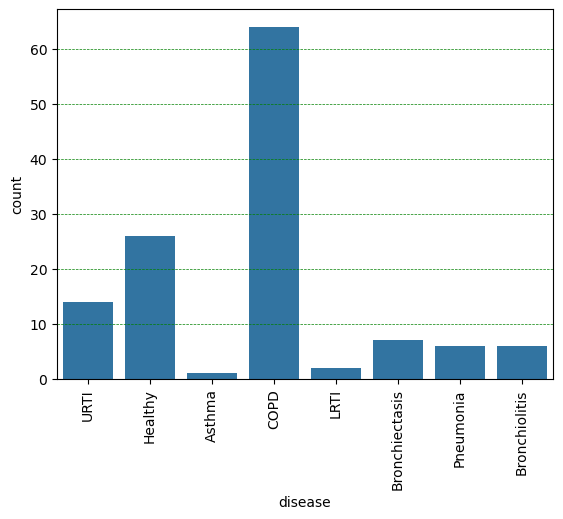

In [104]:
sns.countplot(x='disease', data=diagnosis_df)
plt.xticks(rotation=90)
plt.grid(axis='y', color='green', linestyle='--', linewidth=0.5)
plt.show()


In [105]:
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [106]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretches(data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [107]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretches(y, rate=1.2)
    y_stretch_2 = stretches(y, rate=0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr, color='blue')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr, color='blue')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr, color='blue')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr, color='blue')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr, color='blue')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr, color='blue')
    plt.title('pitch shift')

    plt.tight_layout()

In [108]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretches(y, 1.2)
    y_stretch_2 = stretches(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')
    
    

    plt.tight_layout()

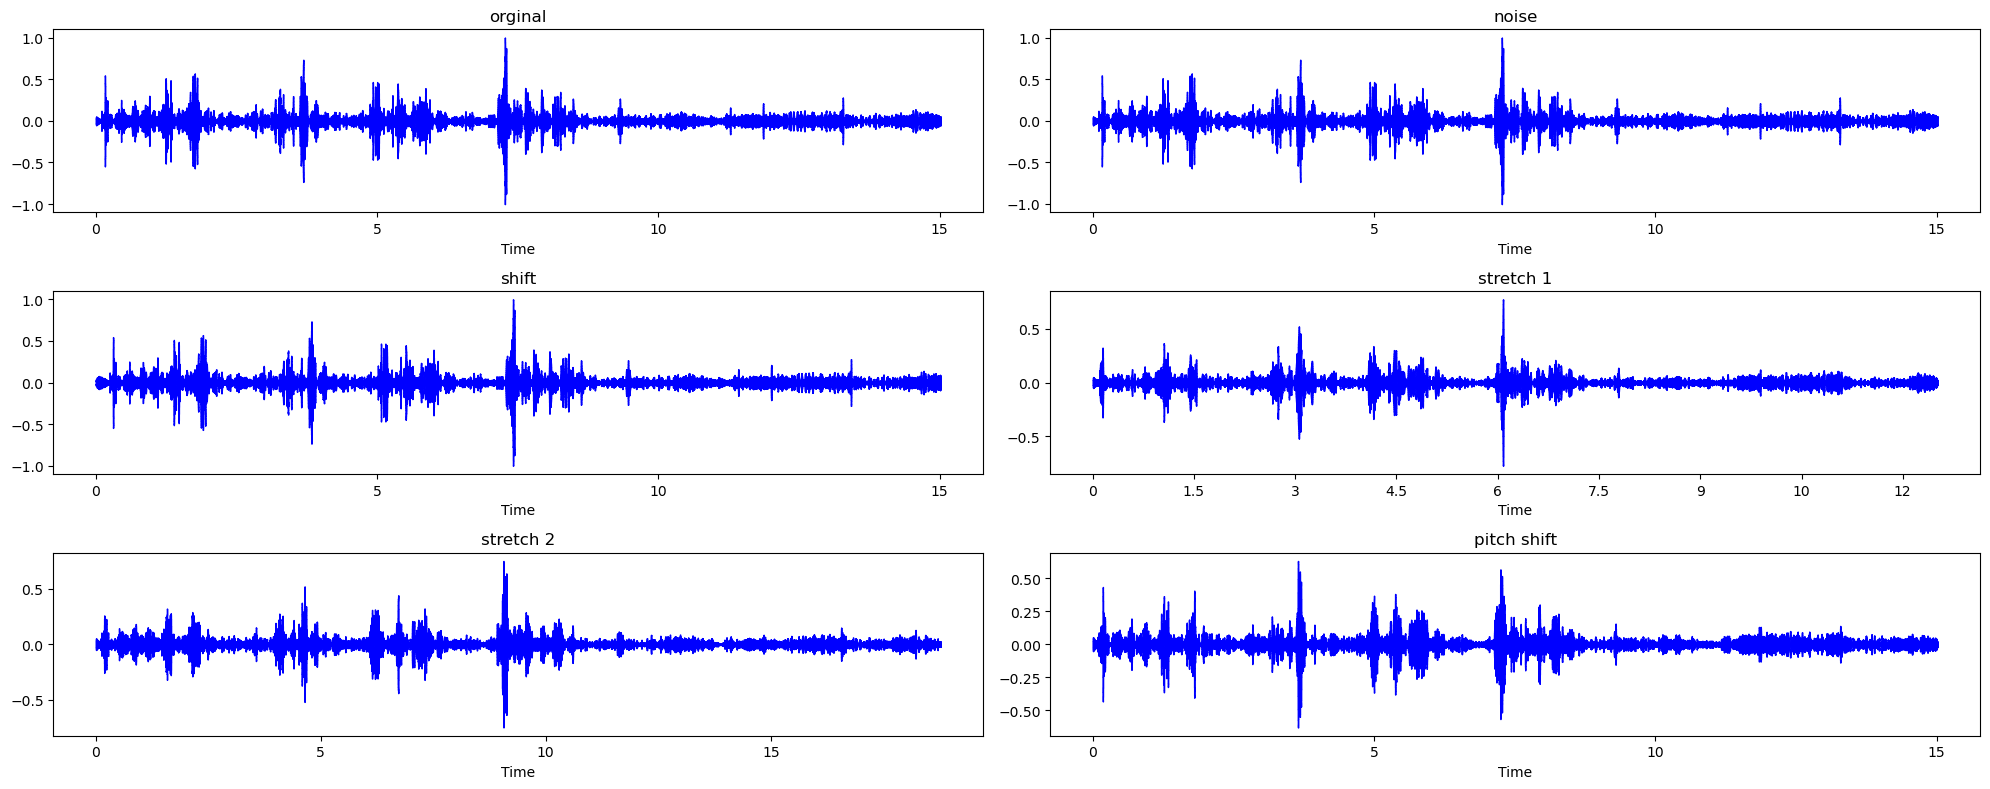

In [109]:
show_audio('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

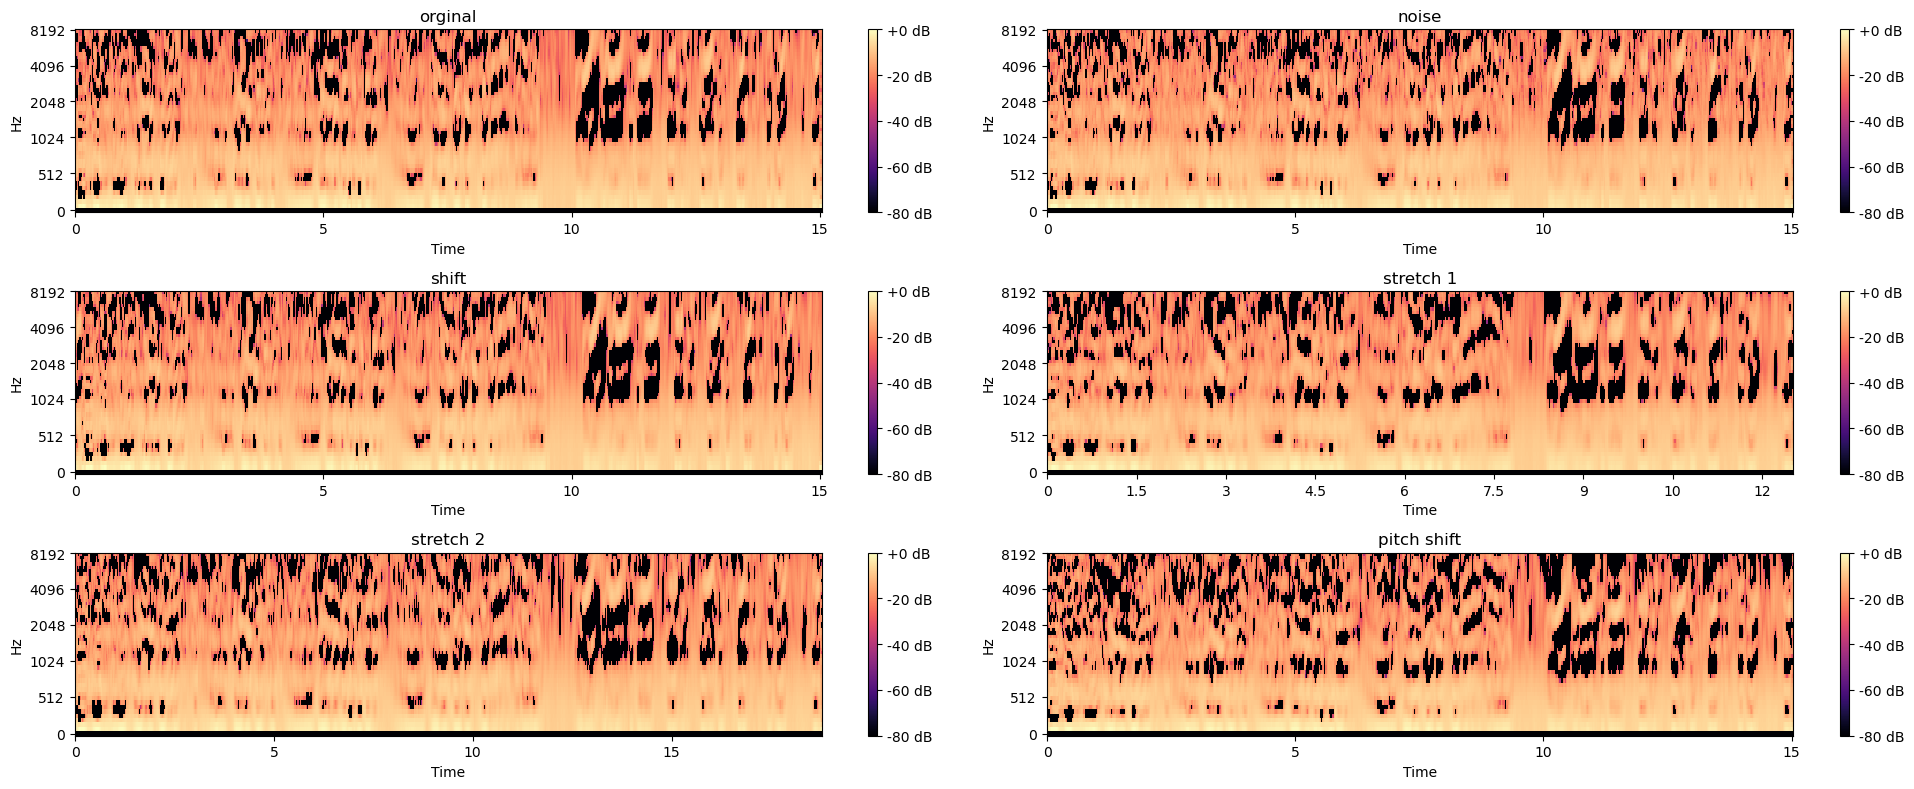

In [110]:
show_audio_features('Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

In [111]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model. 
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables. 
        
        Args: dir_: Input directory to the Sound input file.
        
        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]
    
    COPD=[]
    copd_count=0
    
    data = diagnosis_df
    features = 52
    
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                    
                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
            if (p!='COPD'):
                if (p == 'Bronchiolitis'):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                elif p == 'Bronchiectasis':
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiectasis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiectasis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiectasis')
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiectasis')
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiectasis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiectasis')
                    
                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    
                
    X_data = np.array(X_)
    y_data = np.array(y_)

    
    return X_data, y_data 

In [112]:
x_mfccs, y = mfccs_feature_exteraction(audio_data)

In [113]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

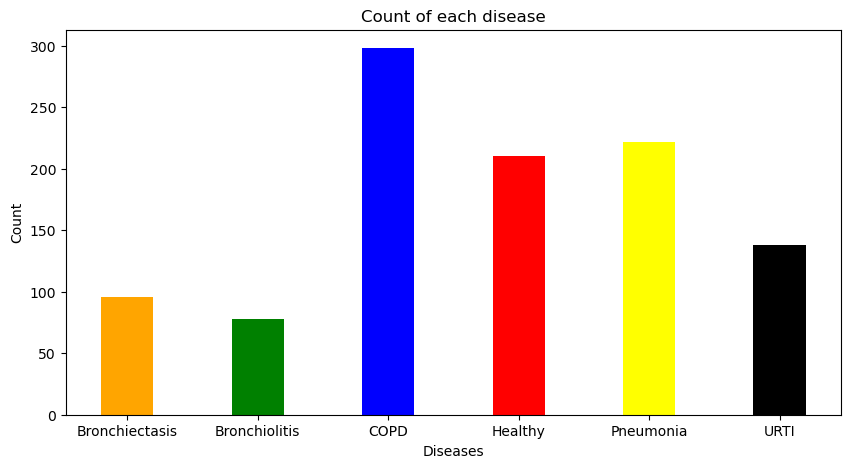

{'Bronchiectasis': 96, 'Bronchiolitis': 78, 'COPD': 298, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [114]:
augmented_lables_count(y)

In [115]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiectasis',np.array([0,0,1,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,0,1,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,0,1,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,0,1]).reshape(1,6) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [116]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((1042, 52), (1042, 6))

In [117]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(794, 52) (183, 52) (65, 52)
(794, 6) (183, 6) (65, 6)


In [118]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [119]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [120]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=6, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(6, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1, 52)]              0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 1, 256)               80128     ['input_4[0][0]']             
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 1, 256)               0         ['conv1d_6[0][0]']            
 g1D)                                                                                             
                                                                                                  
 batch_normalization_6 (Bat  (None, 1, 256)               1024      ['max_pooling1d_6[0][0]'

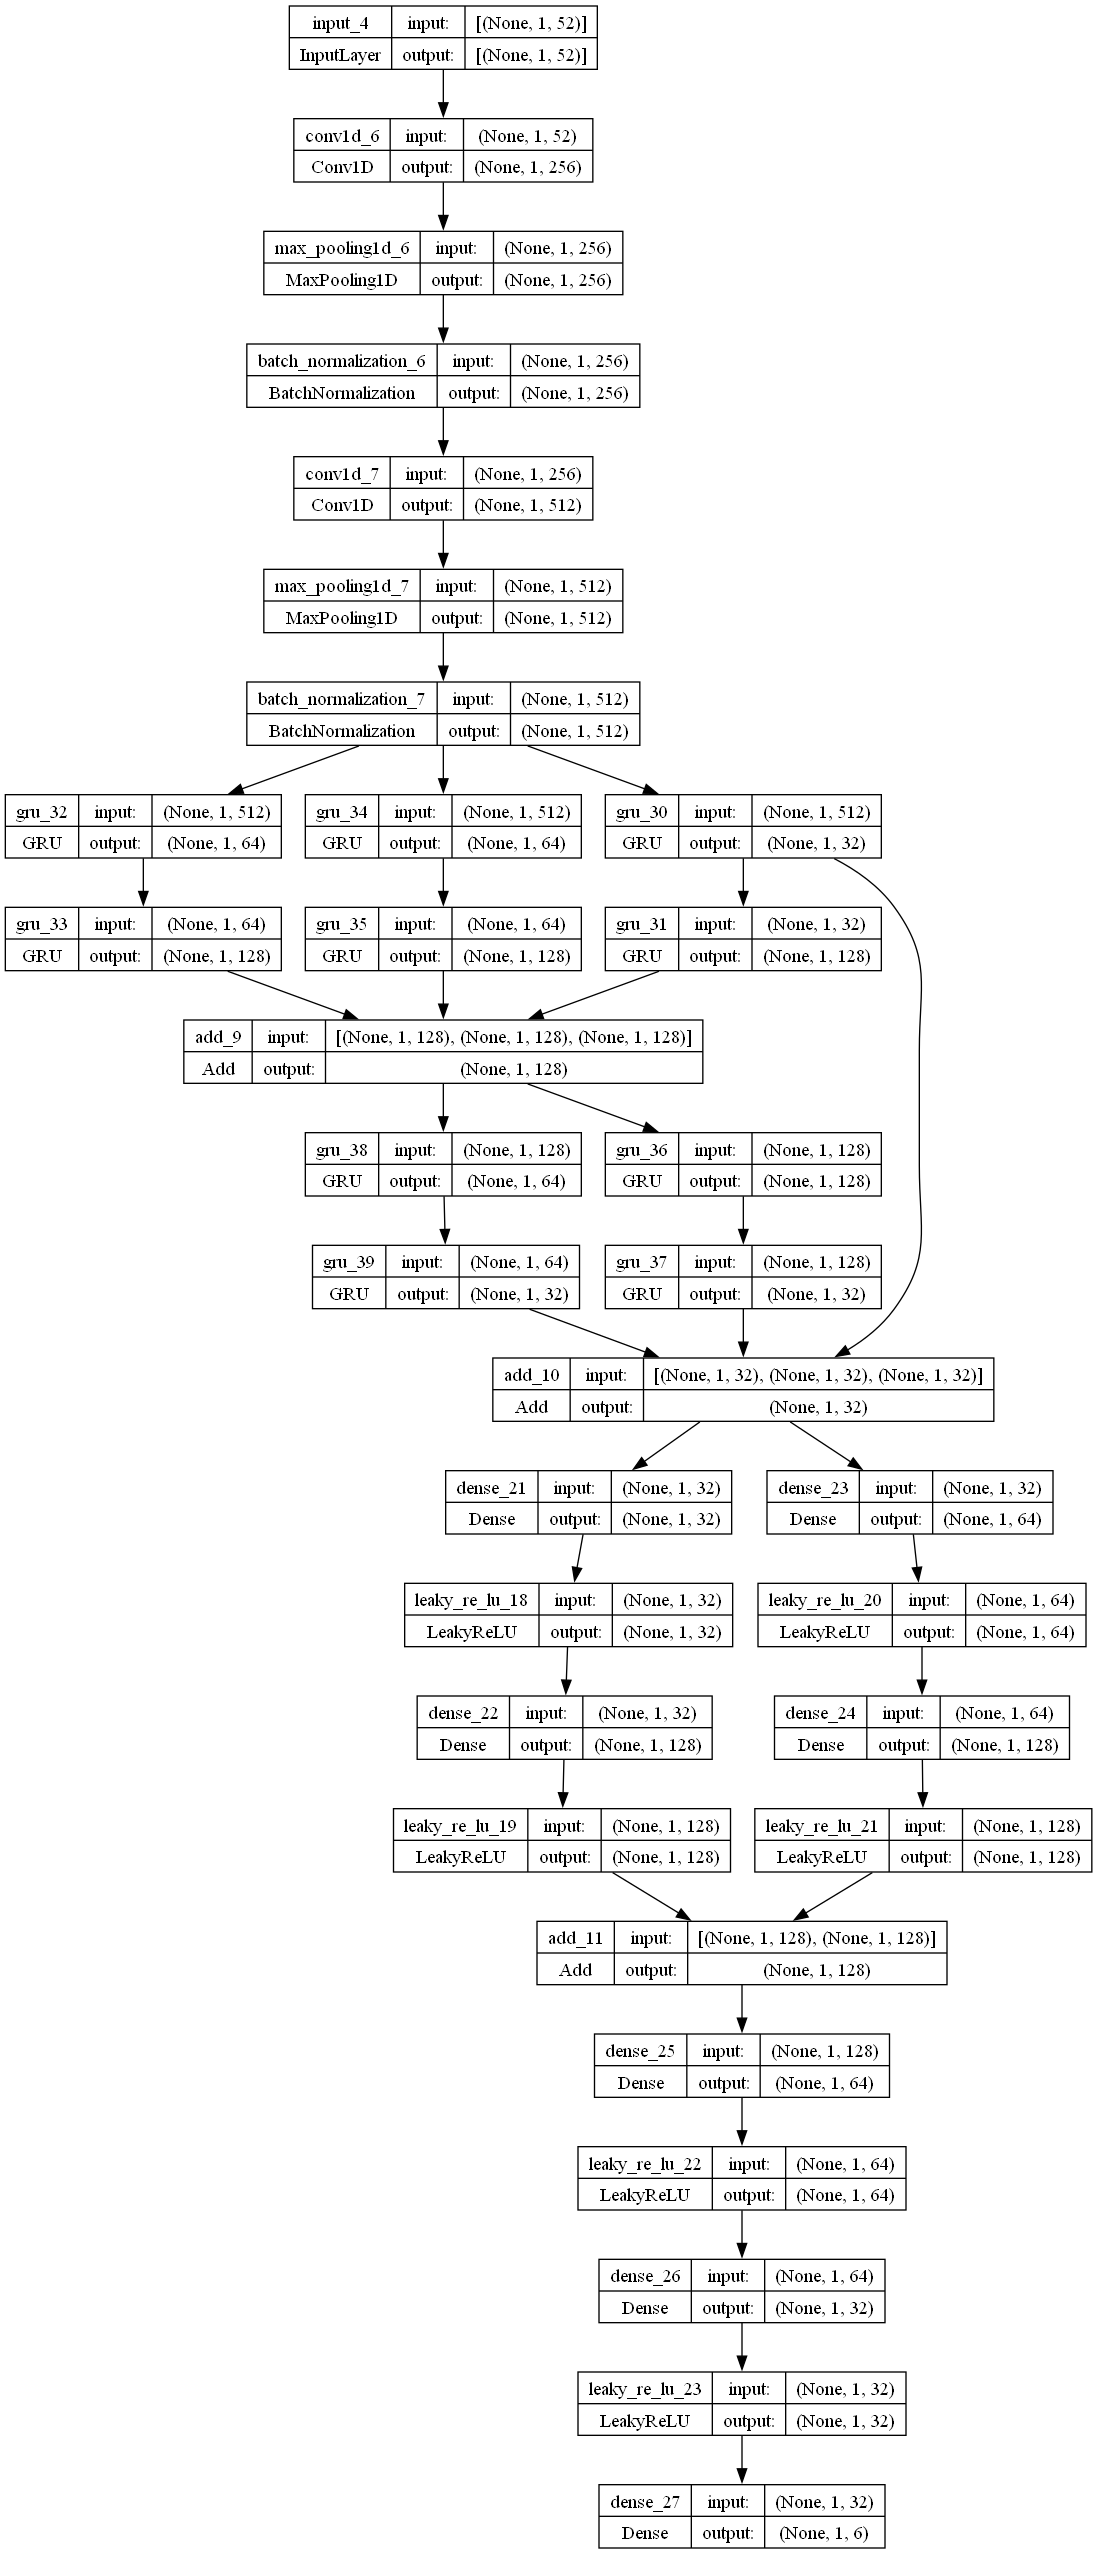

In [121]:
tf.keras.utils.plot_model(gru_model, to_file='gru_model.png', show_shapes=True)

In [122]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

In [123]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=200, validation_data=(x_val_gru, y_val_gru))

Epoch 1/200
100/100 [==============================] - 15s 31ms/step - loss: 1.5640 - accuracy: 0.3917 - val_loss: 1.6436 - val_accuracy: 0.3497
Epoch 2/200
100/100 [==============================] - 1s 13ms/step - loss: 1.2637 - accuracy: 0.5239 - val_loss: 1.3459 - val_accuracy: 0.5355
Epoch 3/200
100/100 [==============================] - 1s 12ms/step - loss: 1.1354 - accuracy: 0.5504 - val_loss: 1.1637 - val_accuracy: 0.5410
Epoch 4/200
100/100 [==============================] - 1s 13ms/step - loss: 1.0478 - accuracy: 0.6083 - val_loss: 0.9683 - val_accuracy: 0.6066
Epoch 5/200
100/100 [==============================] - 1s 12ms/step - loss: 0.9272 - accuracy: 0.6335 - val_loss: 0.9133 - val_accuracy: 0.6448
Epoch 6/200
100/100 [==============================] - 1s 12ms/step - loss: 0.9165 - accuracy: 0.6360 - val_loss: 0.8533 - val_accuracy: 0.6557
Epoch 7/200
100/100 [==============================] - 1s 12ms/step - loss: 0.8500 - accuracy: 0.6612 - val_loss: 0.7898 - val_accuracy

25/25 [==============================] - 0s 5ms/step - loss: 0.1551 - accuracy: 0.9433


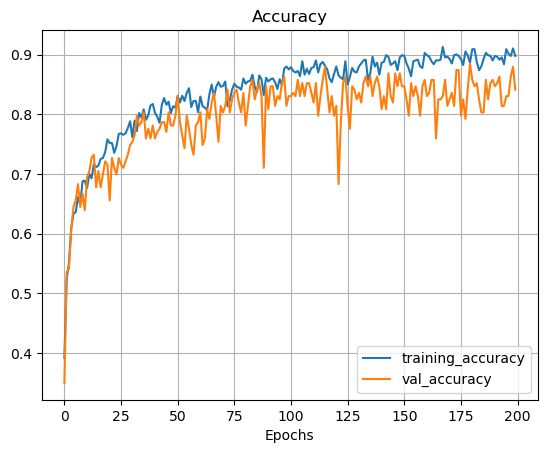

In [124]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)

3/3 [==============================] - 2s 4ms/step


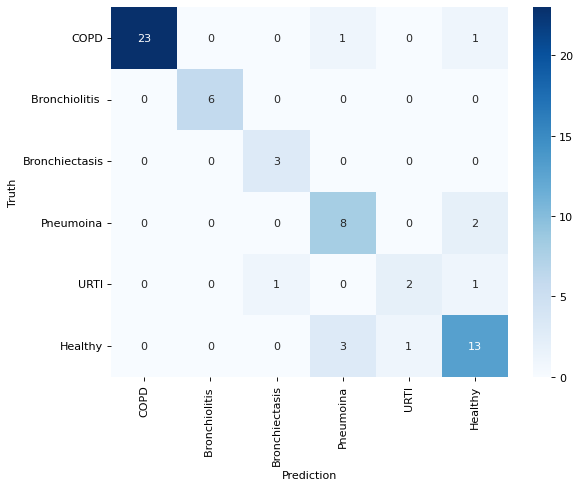

In [125]:
classes = ["COPD" ,"Bronchiolitis ", "Bronchiectasis", "Pneumoina", "URTI", "Healthy"]

preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [126]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.92      0.96        25
Bronchiolitis        1.00      1.00      1.00         6
Bronchiectasis       0.75      1.00      0.86         3
     Pneumoina       0.67      0.80      0.73        10
          URTI       0.67      0.50      0.57         4
       Healthy       0.76      0.76      0.76        17

      accuracy                           0.85        65
     macro avg       0.81      0.83      0.81        65
  weighted avg       0.86      0.85      0.85        65



In [127]:
test_loss, test_acc = gru_model.evaluate(x_train_gru, y_train_gru)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

25/25 [==============================] - 0s 5ms/step - loss: 0.1551 - accuracy: 0.9433
Test Accuracy: 0.9433249235153198
Test Loss: 0.15513736009597778


In [130]:
gru_model.save('gru_model.tf')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: gru_model.tf\assets


INFO:tensorflow:Assets written to: gru_model.tf\assets


In [129]:
gru_model.save_weights('my_model2.weights.h5')